In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset and convert into DataFrame
file_path = "/content/drive/My Drive/Colab Notebooks/IMDB Dataset.csv"
df = pd.read_csv(file_path, usecols=['review', 'sentiment'])
print(df.head())
print(df.isnull().sum())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
review       0
sentiment    0
dtype: int64


In [ ]:
# Text Preprocessing Function
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'\d+', ' ', text)  # Remove numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Keep only words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens


# Apply text cleaning
df['tokens'] = df['review'].apply(clean_text)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Display sample
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,1,"[one, reviewers, mentioned, watching, oz, epis..."
1,A wonderful little production. <br /><br />The...,1,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,0,"[basically, theres, family, little, boy, jake,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, matteis, love, time, money, visually,..."


In [ ]:
#Load Pre-trained Word2Vec Embeddings
word_vectors = api.load("word2vec-google-news-300")  # 300-D Word2Vec embeddings

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Function to Create the Embedding Matrix
def get_embedding_matrix(word_index, embedding_dim=300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # Initialize matrix
    for word, i in word_index.items():
        if word in word_vectors:
            embedding_matrix[i] = word_vectors[word]  # Assign pre-trained vector
    return embedding_matrix


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [ ]:
# Tokenize and Convert Text to Sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])
X = pad_sequences(sequences, maxlen=200)
y = pd.get_dummies(df['sentiment']).values  # Convert labels to binary

# Create the embedding matrix
embedding_matrix = get_embedding_matrix(tokenizer.word_index)


In [ ]:
print("Embedding matrix min/max:", embedding_matrix.min(), embedding_matrix.max())
print("Empty sequences:", sum(len(seq) == 0 for seq in sequences))


Embedding matrix min/max: -1.2578125 1.3828125
Empty sequences: 0


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300,
              weights=[embedding_matrix], input_length=200, trainable=False),
    LSTM(128, activation='tanh', recurrent_activation='sigmoid'),  # Fix activation
    Dense(2, activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
print("y shape:", y.shape)
print("y sample:", y[:5])


y shape: (50000, 2)
y sample: [[False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]]


In [ ]:

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(X, y, epochs=5, batch_size=128, validation_split=0.2)

# Print Final Accuracy
train_acc = history.history['accuracy'][-1]  # Last epoch training accuracy
val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

# -----------------------------------
# **Display Term Frequency (TF) Matrix**
vectorizer = TfidfVectorizer(max_features=1000, token_pattern=r"(?u)\b[a-zA-Z]{2,}\b")  # Limit vocabulary for visualization
tf_matrix = vectorizer.fit_transform(df['review'])

# Convert to DataFrame
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print("\nTF Matrix (Sample):")
print(tf_df.head())


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9722 - loss: 0.0756 - val_accuracy: 0.8797 - val_loss: 0.4520
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9829 - loss: 0.0543 - val_accuracy: 0.8799 - val_loss: 0.4920
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9870 - loss: 0.0404 - val_accuracy: 0.8745 - val_loss: 0.5230
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9915 - loss: 0.0284 - val_accuracy: 0.8747 - val_loss: 0.5387
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9913 - loss: 0.0283 - val_accuracy: 0.8709 - val_loss: 0.5960
Final Training Accuracy: 0.9919
Final Validation Accuracy: 0.8709

TF Matrix (Sample):
   able     about  above  absolutely  across  act  acted    acting    action  \
0   0.0  0.033637    0.0         0.0     0.0  0.0    0.0  0.000000  0.000000   
1   0.0  0.051001    0.0         0.0     0.0  0.0    0.0  0.000000  0.000000   
2   0.0  0.000000    0.0       

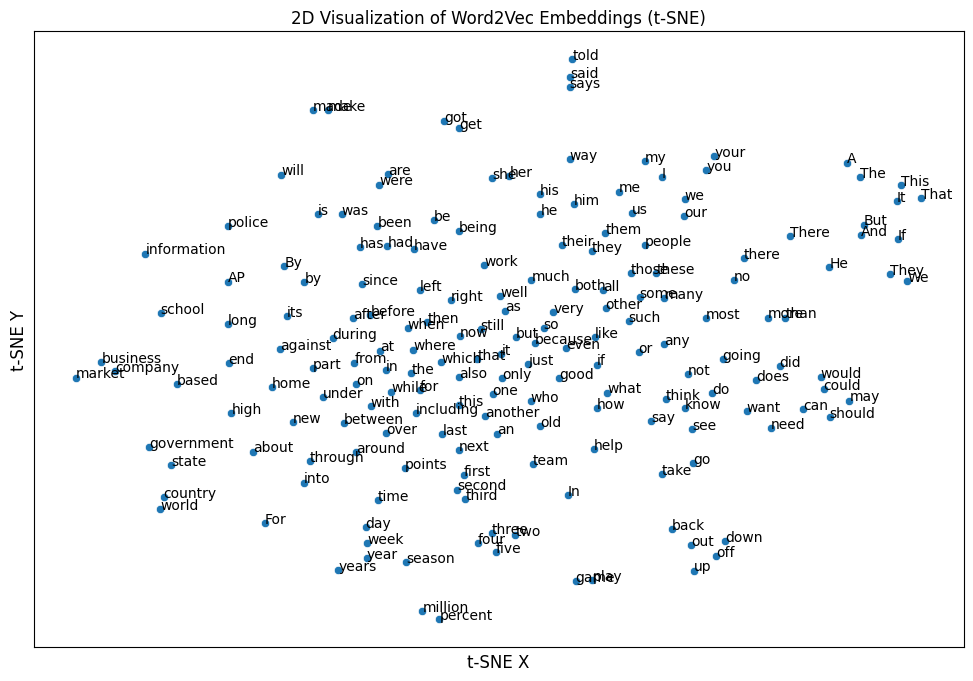

In [ ]:

# **Visualizing Word Embeddings in 2D using t-SNE**
word_list = [word for word in word_vectors.index_to_key[:200] if word.isalpha()]
word_embeddings = np.array([word_vectors[word] for word in word_list])

# Reduce Dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(word_embeddings)

# Plot Word Embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1])

# Annotate a few points
for i, word in enumerate(word_list):  # Label first 30 words
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title("2D Visualization of Word2Vec Embeddings (t-SNE)")
plt.xlabel("t-SNE X", fontsize=12)
plt.ylabel("t-SNE Y", fontsize=12)

# Hide grid and ticks for cleaner look
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.show()